In [6]:
%load_ext autoreload
%autoreload 2
from cppn_torch.activation_functions import *
from matplotlib import pyplot as plt
import imageio.v2 as iio
from tqdm import tqdm
from move import MOVE
from move_config import MoveConfig
from cppn_torch.util import center_crop, resize

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# target_name = "https://upload.wikimedia.org/wikipedia/commons/1/1e/Sunrise_over_the_sea.jpg"
target_name = "https://media.istockphoto.com/id/689364180/vector/smiling-cartoon-face-positive-people-emotion-icon.jpg?s=612x612&w=0&k=20&c=2olrbVI2dkVyR0XKaMs4cSDrzpA4zH4FrCfZ_rKwVjU="


In [8]:
from run_setup import run_setup, fix_target_dimensions
from evolution_torch.algorithm_config import resize_target
config = MoveConfig()
# config.color_mode = "HSL"
config.color_mode = "L"
config.target =  target_name
config.target_name = 'default'
config.target_res = [100, 100]
pilmode = "RGB" if len(config.color_mode) == 3 else "L"
config.target = torch.tensor(iio.imread(config.target, pilmode=pilmode, as_gray=len(config.color_mode)==1), dtype=torch.float32, device=config.device) / 255.0

import cppn_torch.activation_functions as af
import fitness.fitness_functions as ff
# config.activations = [af.identity]
# config.objective_functions = [ff.mse, ff.mse, ff.mse, ff.mse]


resize_target(config)
fix_target_dimensions(config)


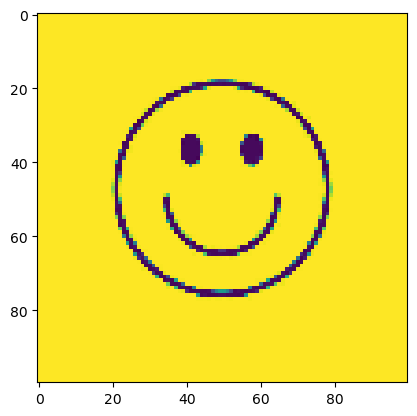

In [9]:

plt.imshow(config.target.cpu().numpy())
plt.show()

In [10]:
move = MOVE(config)

Using 50 out of 364 possible combinations
Number of cells:  50
Initialized MOVE on device: cuda:0


/home/jackson/projects/cppns/cppn_torch/cppn_torch/util.py:251: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fg.show()


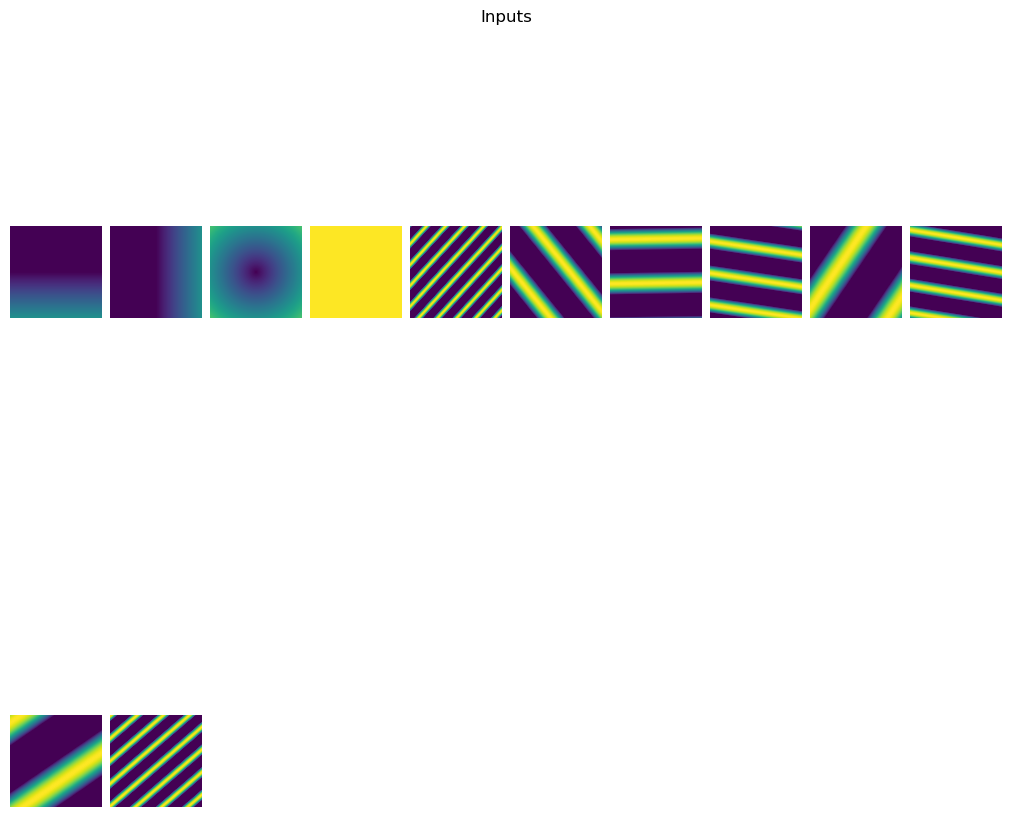

In [11]:
from cppn_torch.util import show_inputs
show_inputs(move.inputs, cols=10)

In [12]:
try:
    move.evolve()
except KeyboardInterrupt:
    pass


Run 1:   0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

/home/jackson/miniconda3/envs/move/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1678411187366/work/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


AssertionError: Non-finite parameters after step

In [ ]:
from baseline import norm_tensor
normed_fits = torch.ones(move.record.fitness_over_time.shape) * -torch.inf
for fn_i in range(move.record.fitness_over_time.shape[0]):
    fn_name = move.fns[fn_i].__name__
    normed_fits[fn_i] = norm_tensor(move.record.fitness_over_time[fn_i], move.config.norm_df_path, fn_name)

plt.plot(normed_fits.mean(dim=(0)).cpu())
plt.show()

KeyboardInterrupt: 

/home/jackson/projects/cppns/cppn_torch/cppn_torch/util.py:251: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fg.show()


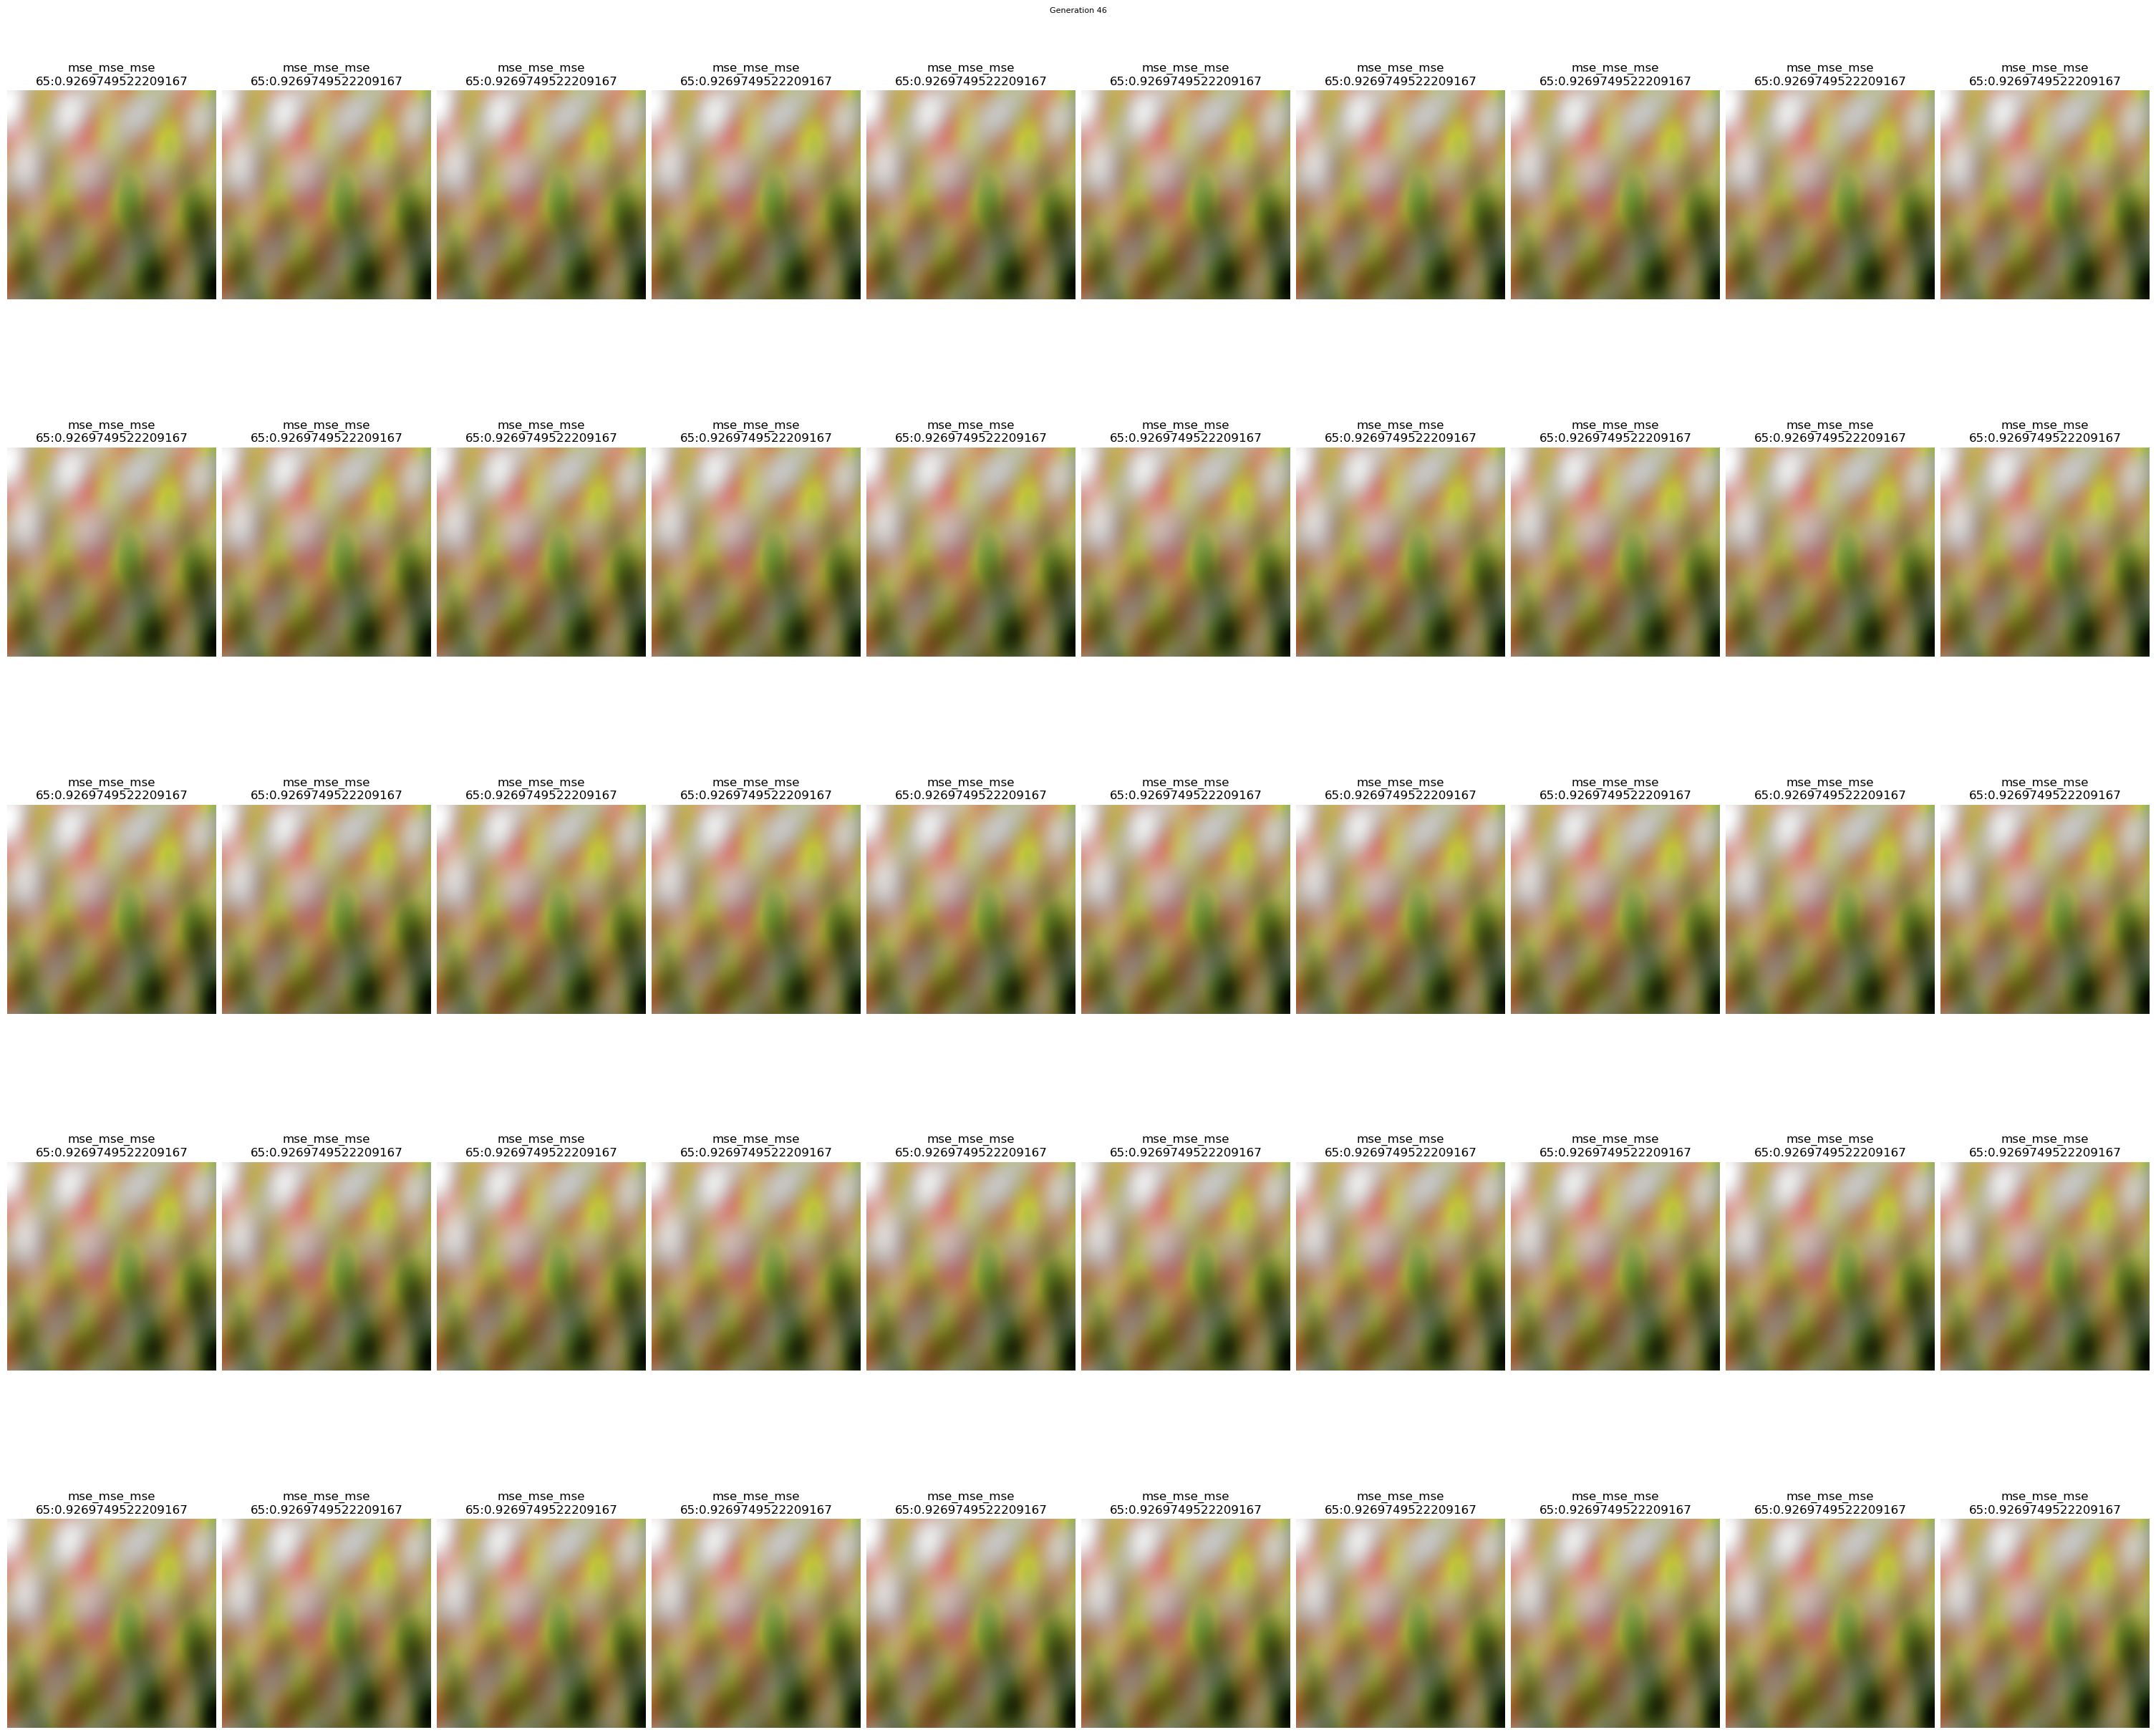

In [ ]:
from util import show_move_map_images
show_move_map_images(move)

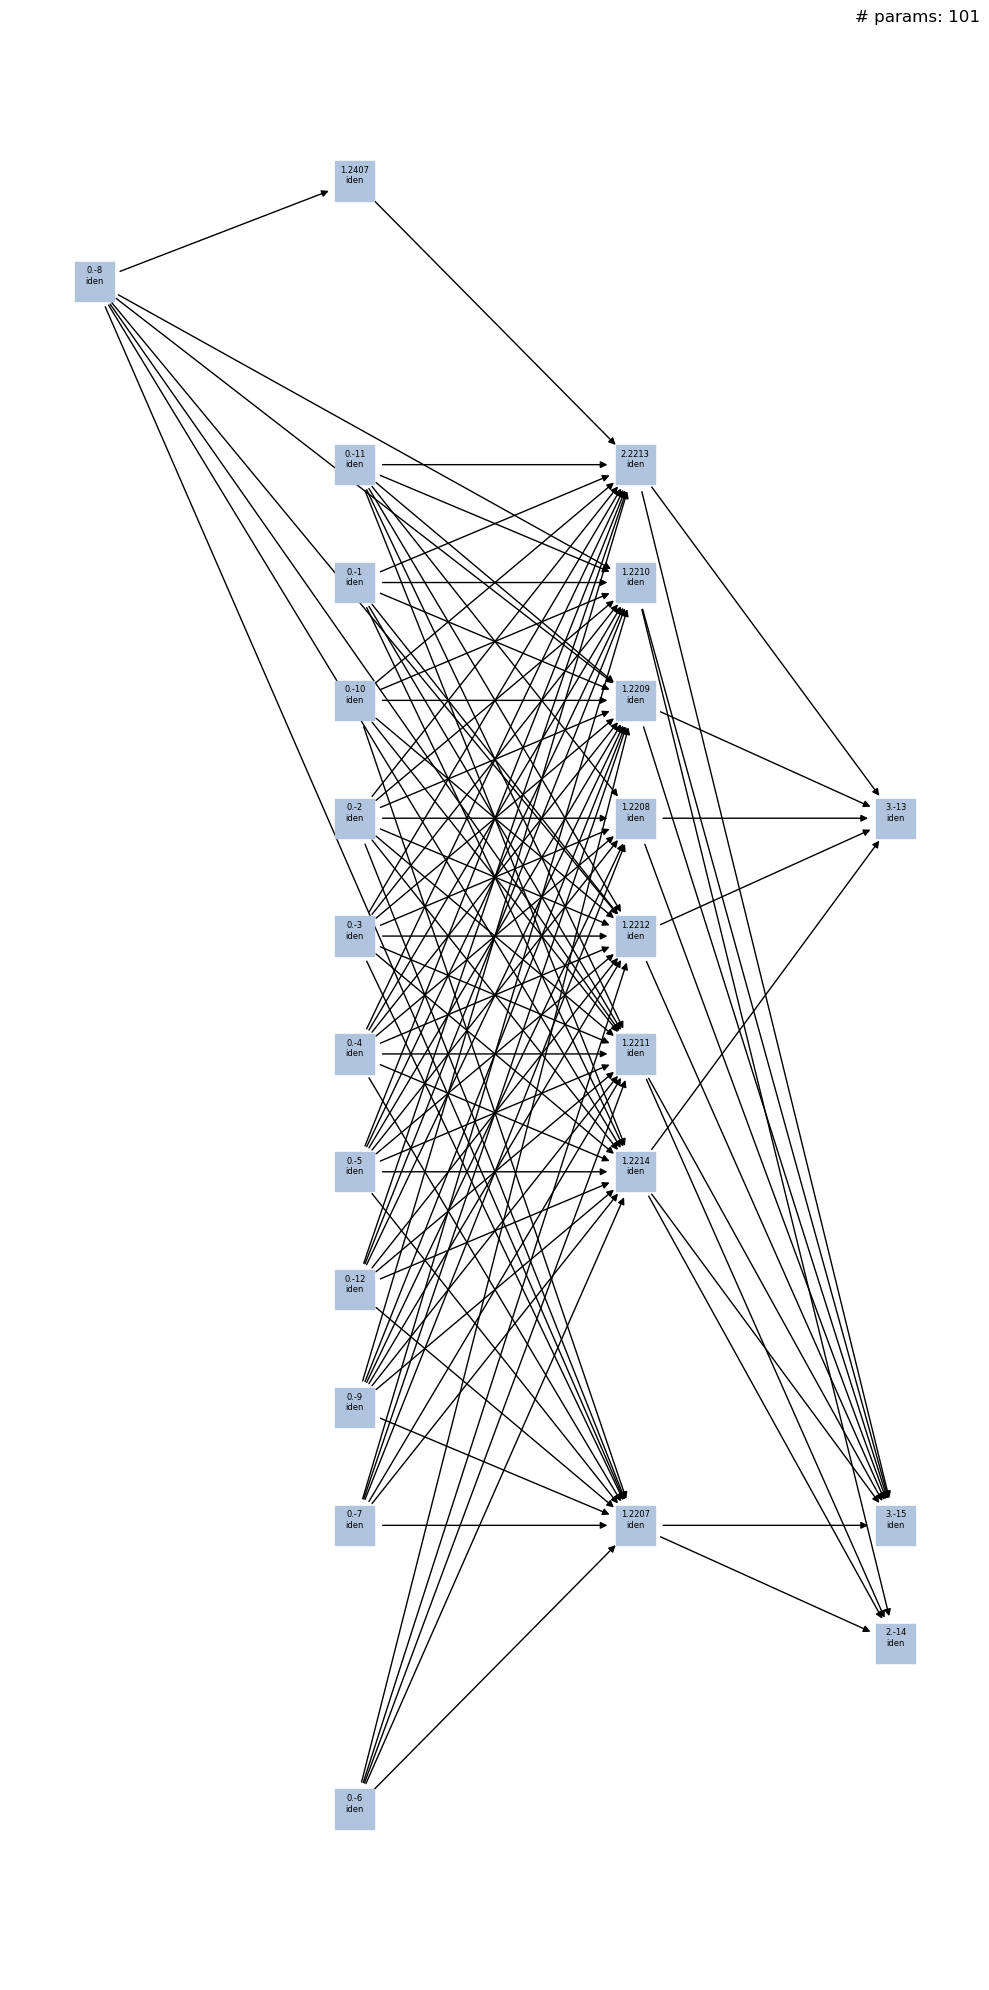

In [ ]:
move.solution.draw_nx()

In [ ]:

from cppn_torch.util import visualize_node_outputs
visualize_node_outputs(move.solution, move.inputs);

plt.show()

In [ ]:
print(f"{'Individual in cell' :20s}  {'Lineage'}")
print('-' * 40)
for cell_id, lineage in enumerate(move.get_lineages()):
    print(f"{move.map.cell_names[cell_id]:20s}: {lineage}")
    
print('-' * 40)
print("\n\n* -1: randomly initialized genome")